# Kids Have Skills? 

# Setup

* 2 schools
* 1 class per school
* 94 kids

## In theory, we have data

* Surveys
* Peer Surveys
* Cooperation
* Fixed vs Growth Mindset
* EEG's on concentration tasks
* Network

# Is that really a thing?

# History

## Surveys + PCA + Varimax = Personality

* Cristal & Tupes -- 1958
* Warren Norman -- 1963



# Math



### A Factor Model:
&nbsp;&nbsp;
$$
\mathbf{X} = \mathbf{F}\mathbf{L'} + \mathbf{E}
$$

&nbsp;

### Restrictions
&nbsp;&nbsp;
$$
\mathbf{cov}(\mathbf{F}) = \mathbf{I} \\
\mathbf{cov}(\mathbf{E}) = \mathbf{\Psi} = diag(\mathbf{\Psi})
$$

&nbsp;

### Further restrictions give us PCA
&nbsp;&nbsp;

$$
\mathbf{E} \sim N(0, \mathbf{I})
$$

## Solve for Factors:
&nbsp;&nbsp;

$$
\mathbf{\hat{F}} = \mathbf{X \Psi^{-1} L(L'\Psi^{-1}L)^{-1}}
$$

&nbsp;&nbsp;

## With Identity Error Covariance:
&nbsp;&nbsp;

$$
\mathbf{\hat{F}} = \mathbf{XL}
$$

## Make some rotations

&nbsp;&nbsp;

$$
\mathbf{\hat{F}T(LT)'\Psi^{-1}LT} = \mathbf{X\Psi^{-1}LT} \\
\mathbf{\hat{F}TT'L\Psi^{-1}LTT'} = \mathbf{X\Psi^{-1}LTT'} \\
\mathbf{\hat{F}L\Psi^{-1}L} = \mathbf{X\Psi^{-1}L}
$$

## Simple Structure = Varimax
&nbsp;&nbsp;

$$
\frac{1}{P} \sum_{j=1}^M \bigg( \sum_{i=1}^P\Lambda_{ij}^4 - \bigg( \sum_{i=1}^P\frac{1}{P}\Lambda_{ij}^2\bigg)\bigg)
$$
&nbsp;&nbsp;
Where $\Lambda$ refers to the normalized loadings. This objective will be most useful to us.

In [651]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Math, Latex
from sklearn.decomposition import SparsePCA, PCA
from sklearn.preprocessing import scale, normalize
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score

In [183]:
# %load_ext autoreload
# %autoreload 2
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)

# Run this notebook outside of main module tree
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

# Import our libs
from surveys.personality import *
from utils.factors import *
from factor_rotation._analytic_rotation import target_rotation
from factor_rotation._gpa_rotation import orthomax_objective, GPA, rotateA as rotate
from factor_rotation._wrappers import rotate_factors

Populating the interactive namespace from numpy and matplotlib


In [3]:
X = prep_X(read_surveys("../data"))
bf_survey = X.iloc[:, 0:65]
bf_survey_scaled = pd.DataFrame(scale(bf_survey))
others = X.iloc[:, 65:]
others_scaled = pd.DataFrame(scale(others))
ids = read_surveys("../data").user_id

# Get the big five components, sparse positie loadings for the questions that
# refer to personality traits. 
bigfive_key = pd.read_csv("../data/educatalyst/Auxil/q1_key_bigfive.csv")
bf_comps = get_big_five_comps(bigfive_key)

# Projec the survey data onto those big five personality components
bigfive = big_five_projection(bigfive_key, bf_survey)
bigfive_scaled = big_five_projection(bigfive_key, bf_survey_scaled)

/opt/conda/envs/python2/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


In [675]:
def get_exlained_variance(df, L, PCA = True, p = 5):
    # sklearn mangles the PCA loadings, so we treat it differently
    if PCA:
        F = df.dot(normalize(L).T)
        v =  np.var(F, axis=0)/np.var(df).sum() * 100 
    else:
        v = np.sum(L ** 2, axis=1)/np.var(df).sum() * 100
    print 'Summed variance of first %s components: %s' % (p,v[0:p].sum())
    return v

def plot_corr(A, B, printing=True):
    corr = np.corrcoef(A, B, rowvar = False)
    p = sns.heatmap(pd.DataFrame(corr), center=0)
    plt.show()
    if printing:
        print pd.DataFrame(max_corr(F, bigfive), columns = ["Maximum Factor Correlation"]).T 
    
def rotated_fa(X, rotator, rotate_factors=True, comps=5):
    """ rotator gets called with F factor matrix """
    fa = RotatableFA(comps).fit(X)
    F = fa.transform(X)
    T = rotator(F)
    fa.rotate_components(rotator, rotate_factors)
    F = fa.transform(X)
    return fa.components_,F

def varimax_gpa(F, Y, rotation_method = 'orthogonal', ff = None):
    T = target_rotation(F, Y)
    ff = VarimaxCorrelationObjective(Y) if ff is None else ff
    _,_,T,_ = GPA(F, ff = ff, T = T, rotation_method=rotation_method)
    return T

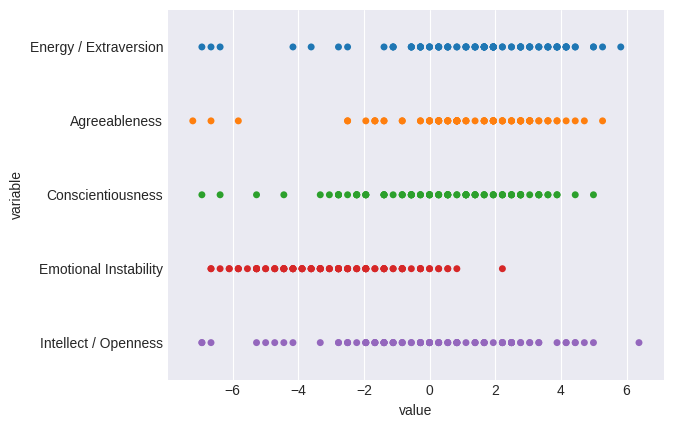

In [707]:
g = sns.stripplot(x = 'value', y = 'variable', data = pd.melt(bigfive), orient = 'h')

In [696]:
bf_pca = PCA(5).fit(bf_survey_scaled)
A = bf_pca.components_.T
V,T = rotate_factors(A, 'varimax')
n = np.stack([
        get_exlained_variance(bf_survey_scaled, A.T), 
        get_exlained_variance(bf_survey_scaled, V.T),
        get_exlained_variance(bf_survey_scaled, bf_comps.T)]).T

pd.DataFrame(n, columns=["Components", "Varimax", "Big Five"]).T

,0,1,2,3,4
Components,23.543123,7.580135,6.321525,5.111549,3.795437
Varimax,14.691594,5.573418,12.284804,7.432257,6.369697
Big Five,7.569611,7.590264,7.664056,6.073631,8.321417


Summed variance of first 5 components: 46.3517700504
Summed variance of first 5 components: 46.3517700504
Summed variance of first 5 components: 37.2189799093


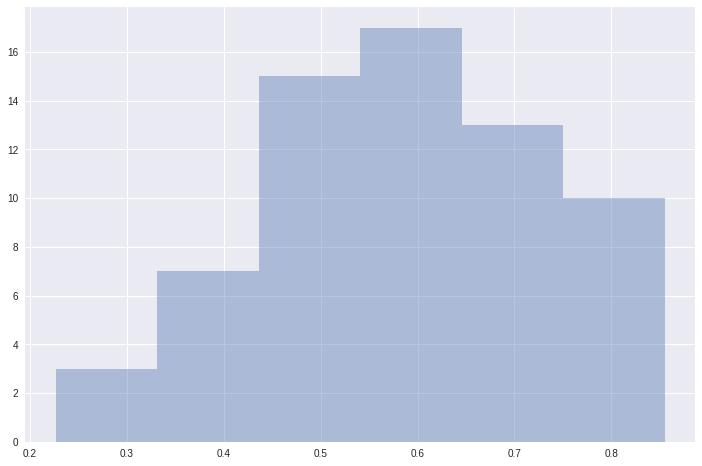

In [434]:
fa = RotatableFA(5).fit(bf_survey_scaled)
F = fa.transform(bf_survey_scaled)
d = sns.distplot(fa.noise_variance_, kde=False)

In [694]:
A,FA = rotated_fa(bf_survey_scaled, lambda F: np.eye(F.shape[1]))
V,FV = rotated_fa(bf_survey_scaled, lambda L: rotate_factors(L.T, 'varimax')[1], False)

n = np.stack([
        get_exlained_variance(bf_survey_scaled, A, False), 
        get_exlained_variance(bf_survey_scaled, V, False),
        get_exlained_variance(bf_survey_scaled, bf_comps.T)]).T

pd.DataFrame(n, columns=["Components", "Varimax", "Big Five"]).T

,0,1,2,3,4
Components,22.586949,6.474895,5.544954,4.367940,2.922496
Varimax,13.645560,10.342161,7.858926,4.543434,5.507152
Big Five,7.569611,7.590264,7.664056,6.073631,8.321417


Summed variance of first 5 components: 41.8972335086
Summed variance of first 5 components: 41.8972335086
Summed variance of first 5 components: 37.2189799093


In [604]:
rotations = {
    'Identity': lambda F: np.eye(F.shape[1]),
    'L2 Orthogonal': lambda F: target_rotation(F, bigfive),
    'Varimax Orthogonal': lambda F: varimax_gpa(F, bigfive),
    'Varimax Oblique': lambda F: varimax_gpa(F, bigfive, 'oblique')    
}

all_factors_bf = {k: rotated_fa(bf_survey_scaled, fn)[1] for k,fn in rotations.iteritems()}
all_factors_others = {k: rotated_fa(others_scaled, fn)[1] for k,fn in rotations.iteritems()}

In [626]:
n = np.array([max_corr(f, bigfive) for f in all_factors_bf.values()])
print pd.DataFrame(n, index = all_factors_bf.keys()).to_latex()
print '\n'
n = np.array([max_corr(f, bigfive) for f in all_factors_others.values()])
print pd.DataFrame(n, index = all_factors_others.keys()).to_latex()

\begin{tabular}{lrrrrr}
\toprule
{} &         0 &         1 &         2 &         3 &         4 \\
\midrule
Varimax Oblique    &  0.968546 &  0.943092 &  0.922326 &  0.973424 &  0.942151 \\
Varimax Orthogonal &  0.748137 &  0.557080 &  0.369989 &  0.938690 &  0.932587 \\
L2 Orthogonal      &  0.881740 &  0.781647 &  0.747987 &  0.952970 &  0.802980 \\
Identity           &  0.331887 &  0.291065 &  0.359494 &  0.332125 &  0.195156 \\
\bottomrule
\end{tabular}



\begin{tabular}{lrrrrr}
\toprule
{} &         0 &         1 &         2 &         3 &         4 \\
\midrule
Varimax Oblique    &  0.493596 &  0.639058 &  0.489409 &  0.421770 &  0.312784 \\
Varimax Orthogonal &  0.071356 &  0.725579 &  0.316222 &  0.470429 &  0.227975 \\
L2 Orthogonal      &  0.512753 &  0.423017 &  0.546490 &  0.469321 &  0.600568 \\
Identity           &  0.083879 &  0.025884 &  0.107176 &  0.134254 &  0.031207 \\
\bottomrule
\end{tabular}



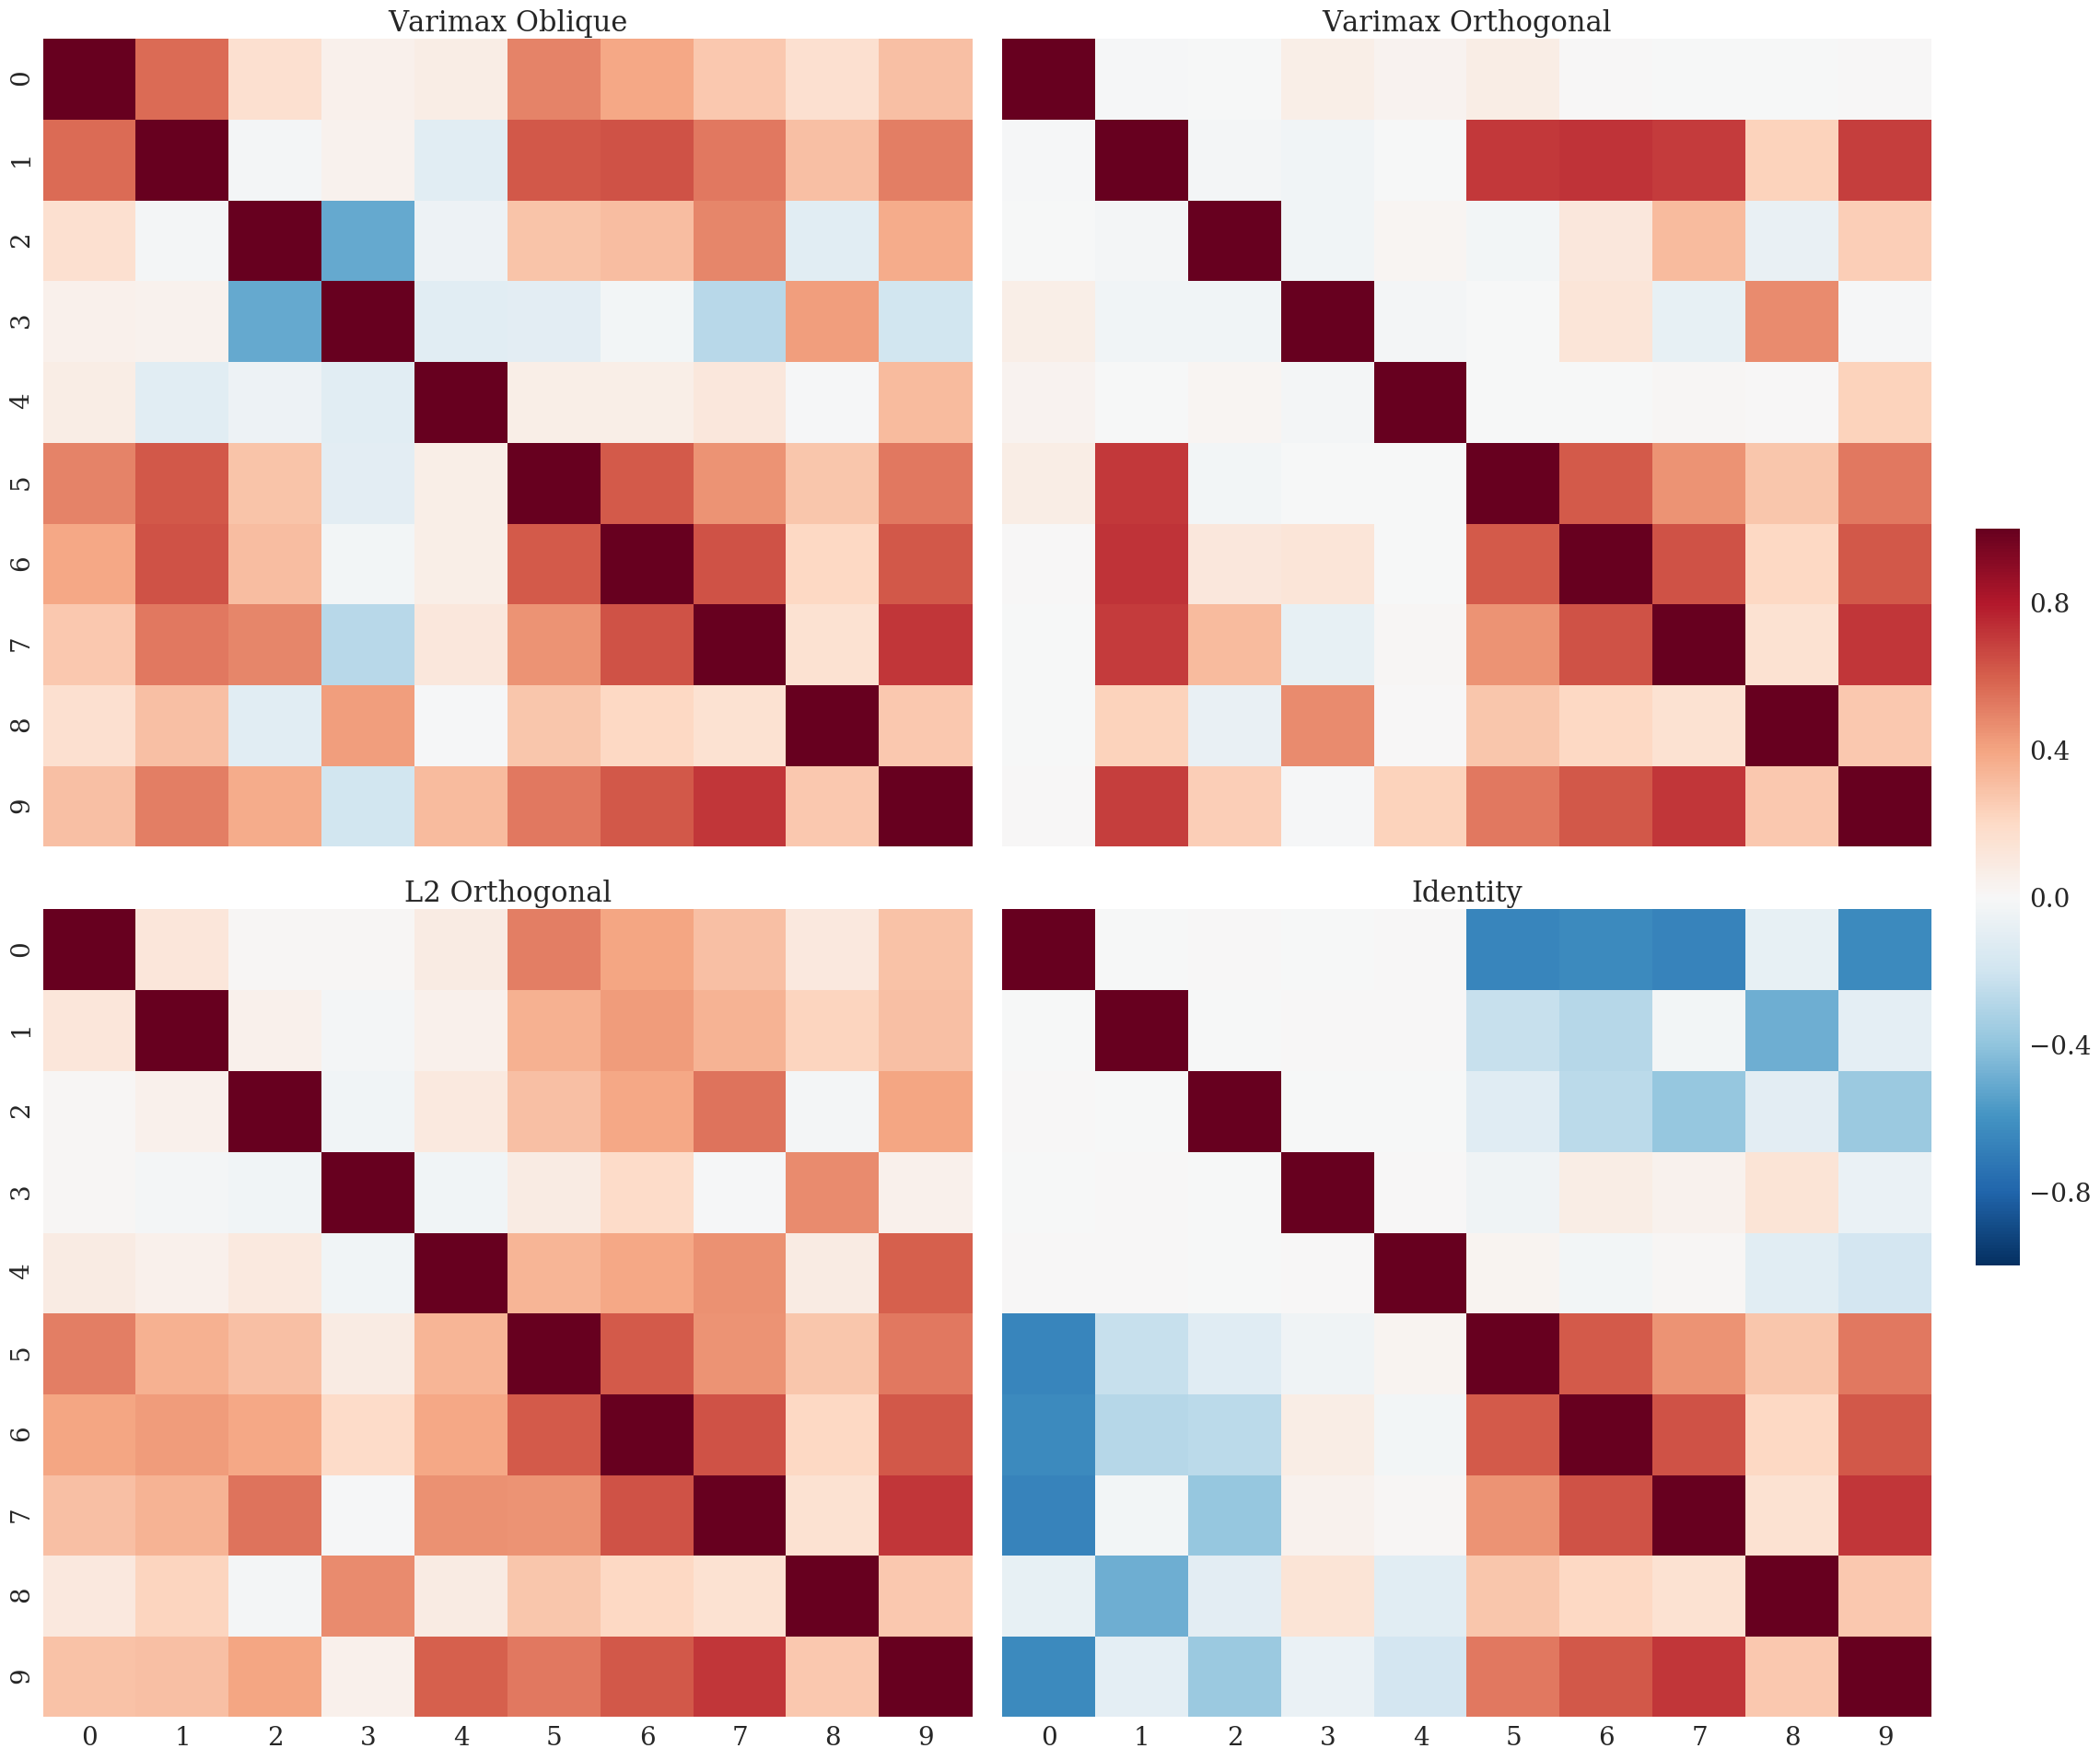

In [670]:
# facet grid practise
# L,F = rotated_fa(bf_survey_scaled, lambda F: np.eye(F.shape[1]))
# L2,F2 = rotated_fa(bf_survey_scaled, lambda F: target_rotation(F, bigfive))

def heatedfacet(Fs, H, titles):
    """Fs is list of Factor matrics, H is target for corr, titles is for grid """
    
    def heatmap(variable, value, **kwargs):
        df = pd.concat([variable, value], axis=1)
        d = np.array([df[df.variable == i].value for i in df.variable.unique()]).T
        A = pd.DataFrame(d)
        corr = np.corrcoef(A, H, rowvar = False)
        p = sns.heatmap(pd.DataFrame(corr), center=0, **kwargs)
        return p

    dfit = lambda d,i: pd.melt(pd.DataFrame(d)).assign(fa = i)    
    Fs = pd.concat([dfit(m,i) for m,i in zip(Fs, titles)])
    sns.set(font_scale=2, font='serif')
    g = sns.FacetGrid(Fs, col='fa', col_wrap=2, size=10, aspect = 1.2)
    cbar_ax = g.fig.add_axes([.92, .3, .02, .4])
    g.map(heatmap, 'variable', 'value', cbar_ax=cbar_ax)
    g.set_axis_labels('', '')
    g.set_titles("{col_name}")
    g.fig.subplots_adjust(right=.9)
    sns.reset_orig()
    return g

heatedfacet(all_factors_others.values(), bigfive, all_factors_others.keys())

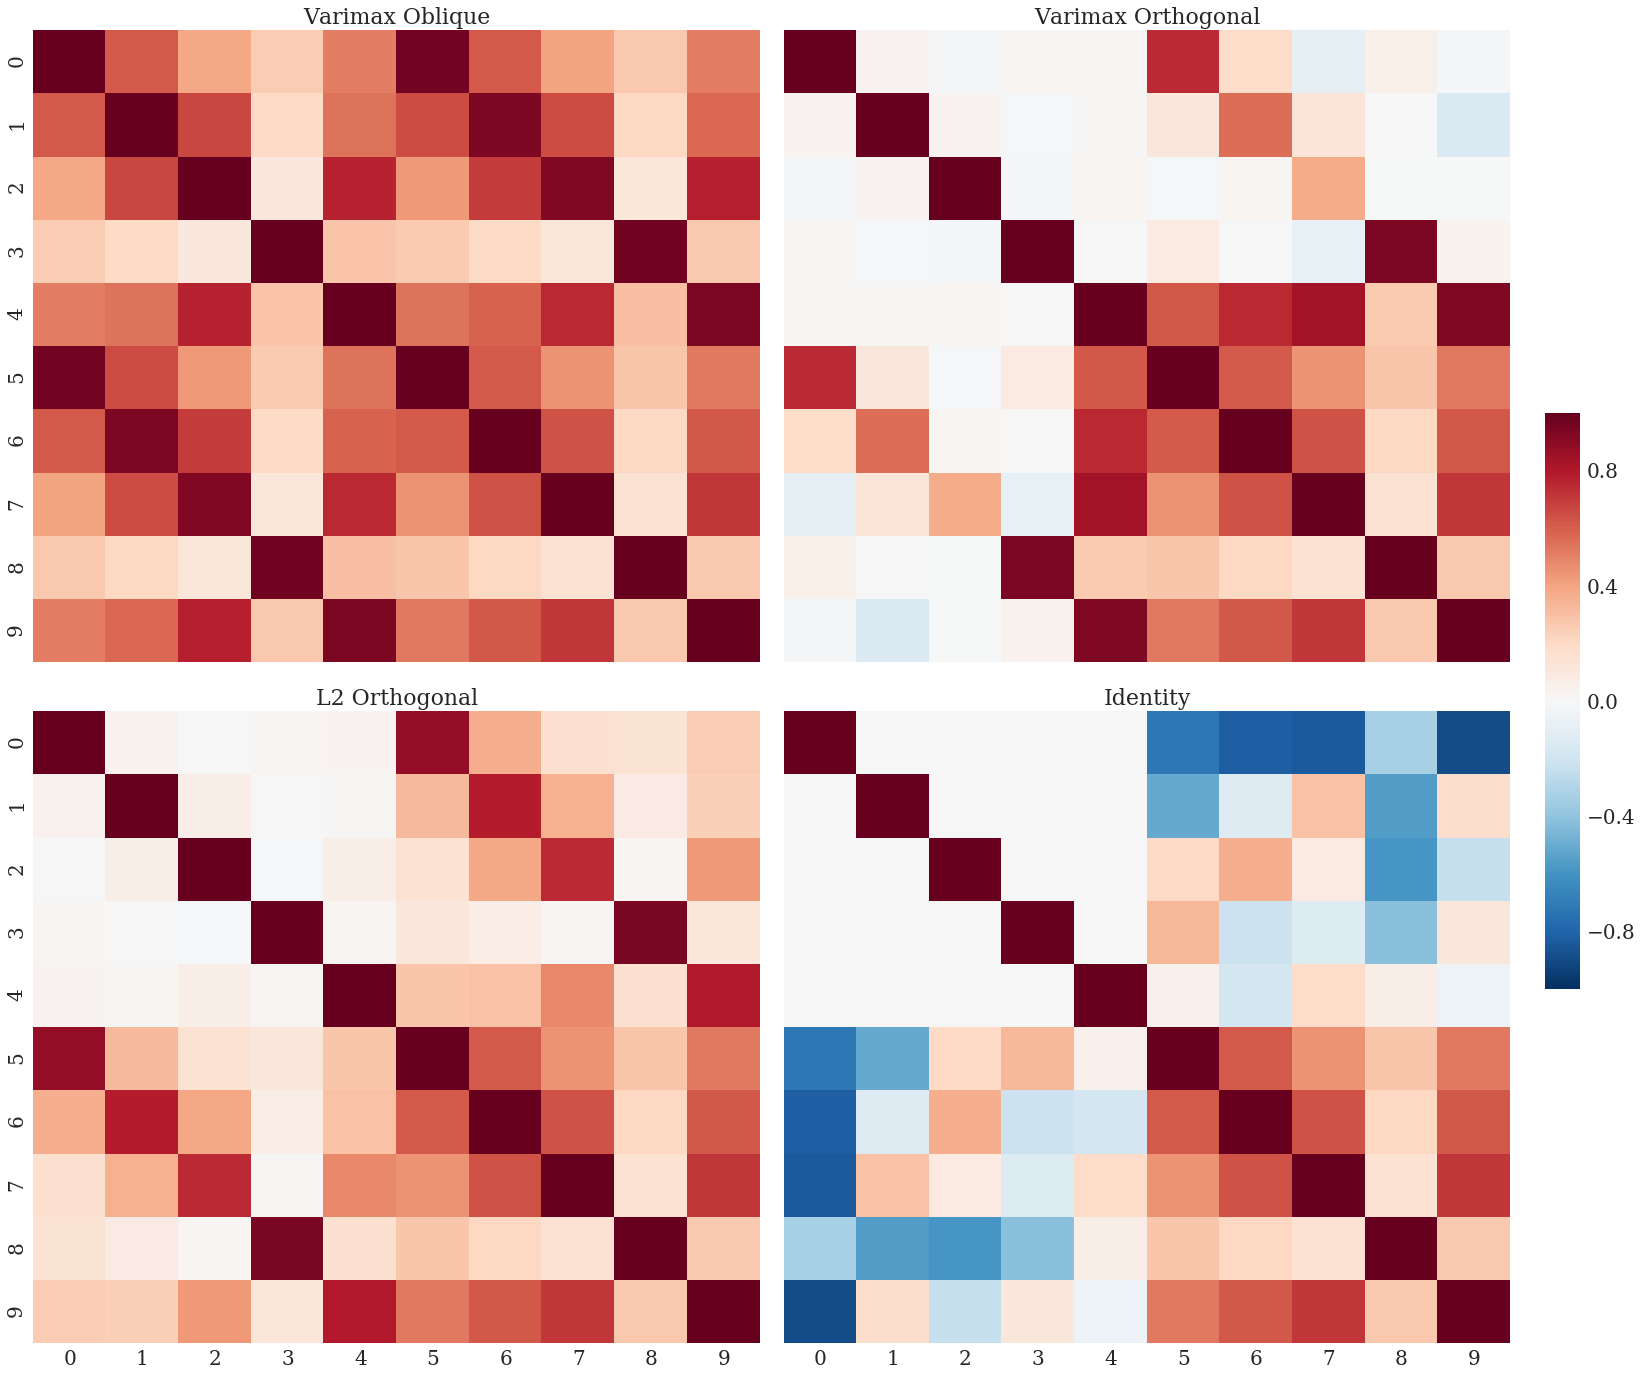

In [637]:
heatedfacet(all_factors_bf.values(), bigfive, all_factors_bf.keys())

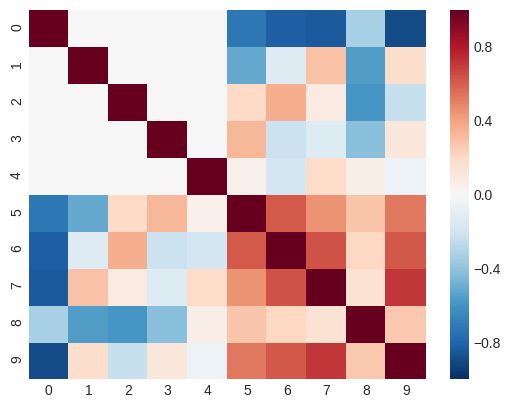

                                   0         1         2         3         4
Maximum Factor Correlation  0.331887  0.291065  0.359494  0.332125  0.195156


In [712]:
# Basic Factor Analysis on Big Five Survey without rotation
L,F = rotated_fa(bf_survey_scaled, lambda F: np.eye(F.shape[1]))
plot_corr(F, bigfive)

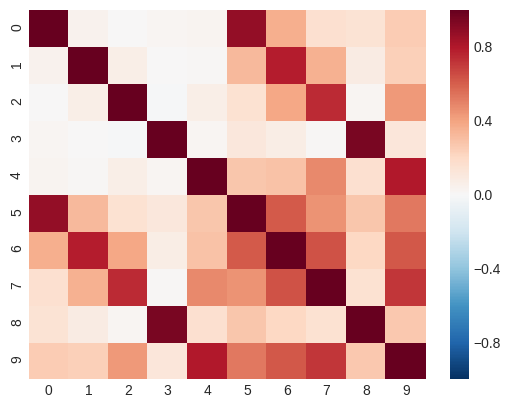

                                  0         1         2        3        4
Maximum Factor Correlation  0.88174  0.781647  0.747987  0.95297  0.80298


In [713]:
# Factor Analysis with factors rotated to minimize L2 Norm with Big Five
L,F = rotated_fa(bf_survey_scaled, lambda F: target_rotation(F, bigfive))
plot_corr(F, bigfive)

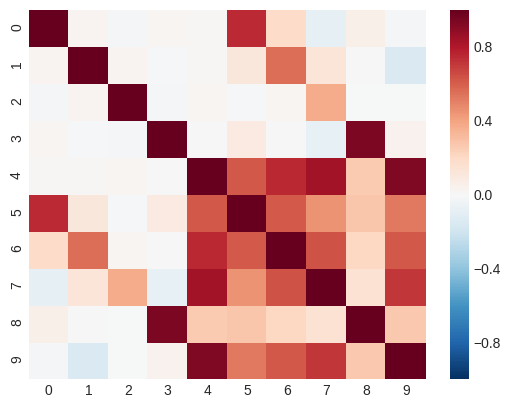

                                   0        1         2        3         4
Maximum Factor Correlation  0.748137  0.55708  0.369989  0.93869  0.932587


In [714]:
# Factor Analysis with factors rotated in order to maximize Varimax objective
# in the correlation matrix with the bigfive factors.
L,F = rotated_fa(bf_survey_scaled, lambda F: varimax_gpa(F, bigfive))
plot_corr(F, bigfive)

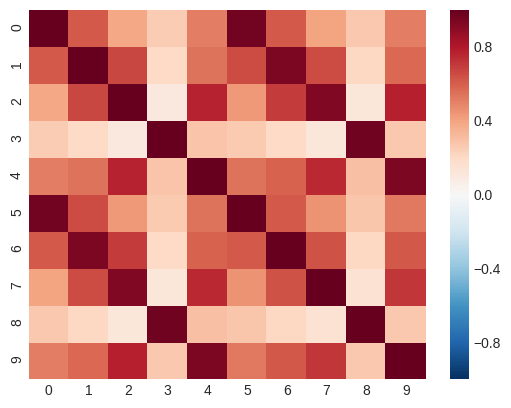

                                   0         1         2         3         4
Maximum Factor Correlation  0.968546  0.943092  0.922326  0.973424  0.942151


In [715]:
L,F = rotated_fa(bf_survey_scaled, lambda F: varimax_gpa(F, bigfive, 'oblique'))
plot_corr(F, bigfive)

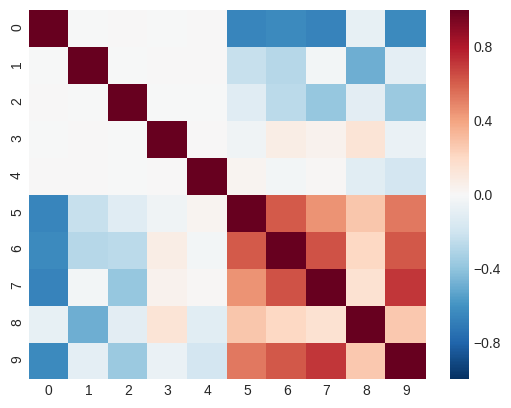

                                   0         1         2         3         4
Maximum Factor Correlation  0.083879  0.025884  0.107176  0.134254  0.031207


In [716]:
L,F = rotated_fa(others_scaled, lambda F: np.eye(F.shape[1]))
plot_corr(F, bigfive)

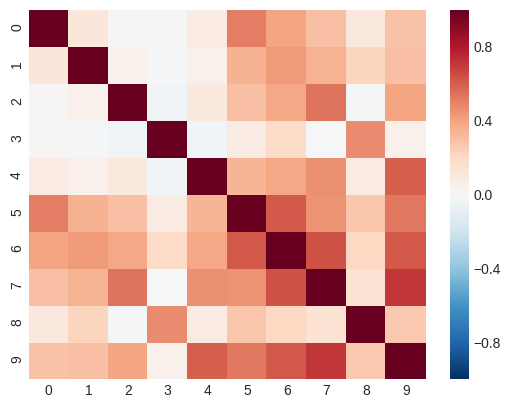

                                   0         1        2         3         4
Maximum Factor Correlation  0.512753  0.423017  0.54649  0.469321  0.600568


In [717]:
L,F = rotated_fa(others_scaled, lambda F: target_rotation(F, bigfive))
plot_corr(F, bigfive)

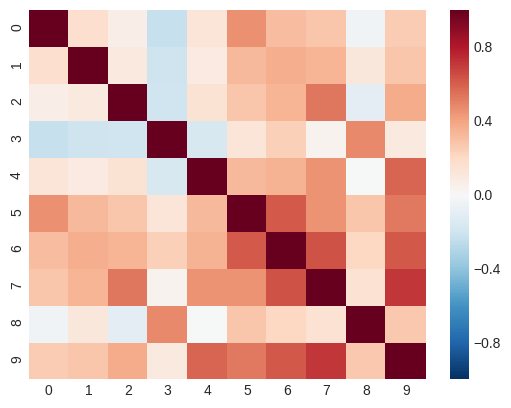

                                  0         1         2         3         4
Maximum Factor Correlation  0.45928  0.364635  0.534948  0.481461  0.580808


In [718]:
def norm(A=None, T=None, L=None):
    L = A.dot(T) if L is None else L
    return np.linalg.norm(L - bigfive, 1)
    
L,F = rotated_fa(others_scaled, lambda F: varimax_gpa(F, bigfive, 'oblique', norm))
plot_corr(F, bigfive)

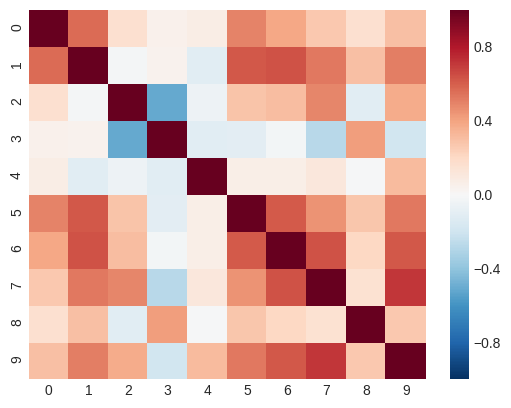

                                   0         1         2        3         4
Maximum Factor Correlation  0.493596  0.639058  0.489409  0.42177  0.312784


In [719]:
L,F = rotated_fa(others_scaled, lambda F: varimax_gpa(F, bigfive, 'oblique'))
plot_corr(F, bigfive)

In [720]:
from sklearn.cross_decomposition import PLSSVD
plssvd = PLSSVD(5).fit(bf_survey_scaled, others_scaled)

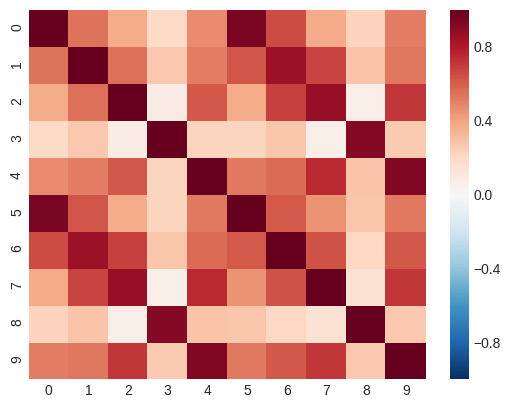

                                   0         1         2         3         4
Maximum Factor Correlation  0.948249  0.858054  0.874393  0.915086  0.923285
Summed variance of first 5 components: 41.7923318685


In [721]:
T = target_rotation(plssvd.x_scores_, bigfive)
F = rotate(plssvd.x_scores_, T)
plot_corr(F, bigfive)
max_corr(F, bigfive)
g = get_exlained_variance(bf_survey, plssvd.x_weights_.T)

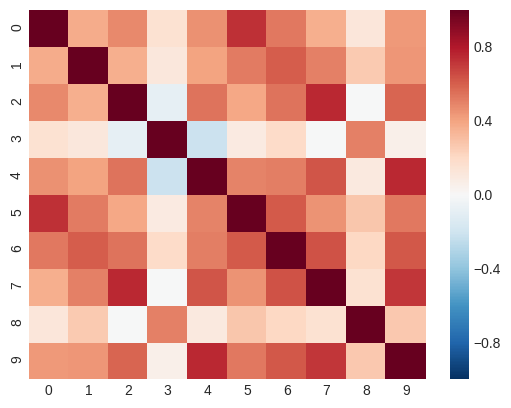

                                   0        1         2         3         4
Maximum Factor Correlation  0.726848  0.60881  0.753055  0.506655  0.750198
Summed variance of first 5 components: 41.1344585457


In [727]:
T = target_rotation(plssvd.y_scores_, bigfive)
F = rotate(plssvd.y_scores_, T)
plot_corr(F, bigfive)
g = get_exlained_variance(others, plssvd.y_weights_.T)

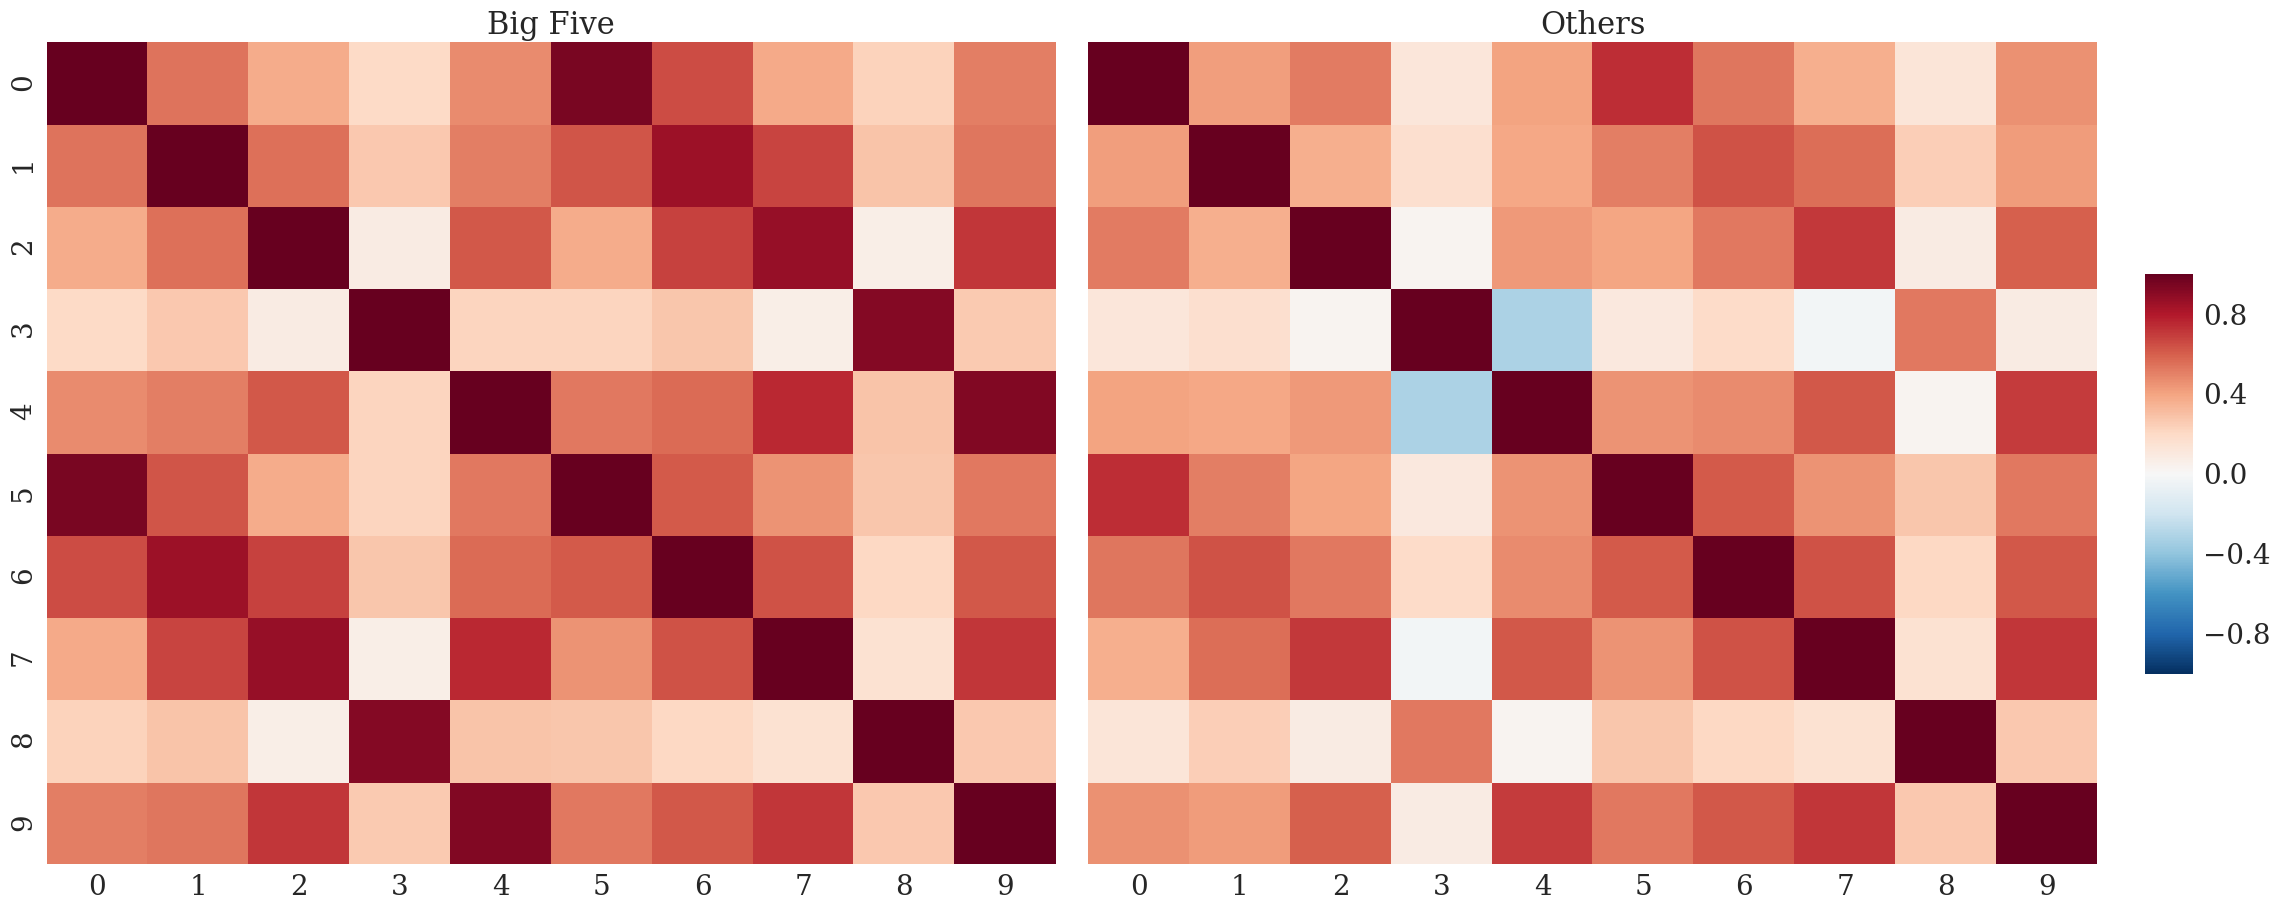

\begin{tabular}{lrrrrr}
\toprule
{} &         0 &         1 &         2 &         3 &         4 \\
\midrule
Big Five &  0.948249 &  0.858054 &  0.874393 &  0.915086 &  0.923285 \\
Others   &  0.741755 &  0.634072 &  0.703748 &  0.530984 &  0.696755 \\
\bottomrule
\end{tabular}



In [674]:
T = target_rotation(plssvd.x_scores_, bigfive)
Fs = [rotate(F, T) for F in [plssvd.x_scores_, plssvd.y_scores_]]
n = np.array([max_corr(f, bigfive) for f in Fs])
print pd.DataFrame(n, index = ['Big Five', 'Others']).to_latex()
heatedfacet(Fs, bigfive, ['Big Five', 'Others'])

# Regression


## Goals

* The Big Five personality traits are alive and well in our population, and measurable through our data-collection techniques.

* One or more of these traits will exist as important latent factors in every measurement we use to predict noncognitive skills of students.

* For each measurement, the exact number or identification of exhibited traits is not determined ahead-of-time, but there will be prior beliefs.

* Relax Gaussianity.
* Relax the linear relationship between latent factors and observed variables.

# Playtime

# Elastic Net

$$
\DeclareMathOperator*{\argmin}{argmin}
\hat{\beta} = argmin_{\beta}||y - \mathbf{X}\beta ||^2 + \lambda_2|| \beta ||^2 + \lambda_1 || \beta ||_1
$$


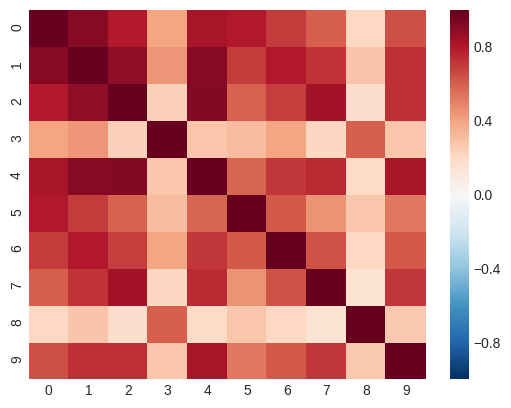

                                   0         1         2         3         4
Maximum Factor Correlation  0.948249  0.858054  0.874393  0.915086  0.923285
Summed variance of first 5 components: 39.3411583718


In [724]:
enet = MultiElasticNet(alpha = 0.4, l1_ratio = .5)
fitted = enet.fit(others, bigfive.as_matrix())
L = np.array(enet.coef_).T
plot_corr(others_scaled.dot(L), bigfive)
g = get_exlained_variance(others, enet.coef_)

# Concerns

>By no means is there any indication of a large general factor, for instance, one attributable to general evaluative tendencies or social desirability, present anywhere in these results... It is thus reassuring to this writer at least, to observe that no factor was found which even closely resembled such a general evaluative response set effect in any of these analyses. --Warren T. Norman

# Wrap Up

* Five factors seem to exist
* Inspiration for prediction

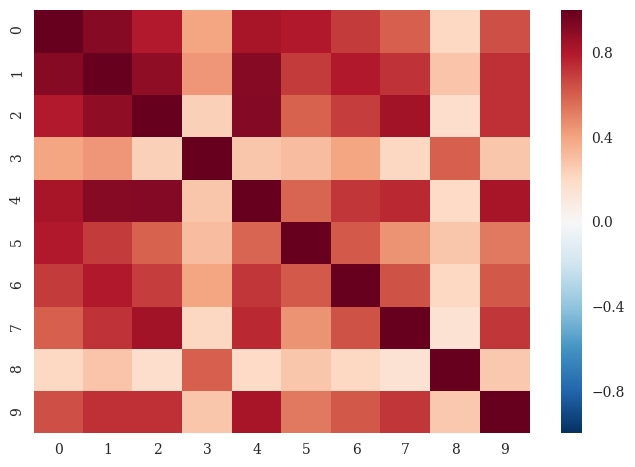

\begin{tabular}{lrrrrr}
\toprule
{} &         0 &         1 &         2 &         3 &         4 \\
\midrule
Linear Regression &  0.800271 &  0.803592 &  0.840472 &  0.599498 &  0.825383 \\
\bottomrule
\end{tabular}



In [691]:
df = pd.DataFrame(max_corr(others_scaled.dot(L), bigfive)).T
df.index = ['Linear Regression']
print df.to_latex()

sns.set(font='serif')
plot_corr(others_scaled.dot(L), bigfive, False)
sns.reset_orig()